# Import de bibliothèques et définition de fonction

In [42]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from category_encoders import TargetEncoder

from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyRegressor
from scipy.stats import f_oneway
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import time

import missingno as msno
import seaborn as sns

In [43]:
df = pd.read_csv('/kaggle/input/projet3-dataset/data.csv', sep=',')
df.head()

pd.set_option('display.max_columns', None)  # Affiche toutes les colonnes


# Nettoyage des données

In [44]:
df.shape

(3376, 46)

In [45]:
df = df[df['Outlier'].isna()]

values_to_remove = ['Error - Correct Default Data', 'Missing Data']
df = df[~df['ComplianceStatus'].isin(values_to_remove)]

df = df.dropna(subset=['NumberofBuildings'])
df = df.dropna(subset=['SiteEnergyUseWN(kBtu)'])
df = df.dropna(subset=['SiteEUI(kBtu/sf)'])

df = df[df['OSEBuildingID'] != 496]
df = df[df['OSEBuildingID'] != 49784]
df = df[df['OSEBuildingID'] != 21611]

single_use_condition = df['ListOfAllPropertyUseTypes'].str.contains(',') == False

missing_gfa_condition = df['LargestPropertyUseTypeGFA'].isna()

df.loc[single_use_condition & missing_gfa_condition, 'LargestPropertyUseTypeGFA'] = df['PropertyGFATotal']

df['SecondLargestPropertyUseTypeGFA'].fillna(0, inplace=True)
df['ThirdLargestPropertyUseTypeGFA'].fillna(0, inplace=True)

condition = (df['NumberofBuildings'] == 0) | (df['NumberofFloors'] == 0)
df = df[~condition]

df.shape

/tmp/ipykernel_24/2443931865.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['SecondLargestPropertyUseTypeGFA'].fillna(0, inplace=True)
/tmp/ipykernel_24/2443931865.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

(3098, 46)

In [46]:
features_to_remove = [
    'PropertyName',
    'Address',
    'TaxParcelIdentificationNumber',
    'CouncilDistrictCode',
    'DBNNumber',
    'DataYear',
    'ZipCode',
    'City',
    'State',
    'Comments',
    'Outlier',
    'ComplianceStatus',
    'DefaultData',
    'YearsENERGYSTARCertified',
    'Latitude',
    'Longitude',
]

df = df.drop(columns=features_to_remove, errors='ignore')

In [47]:
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns

imputer = KNNImputer(n_neighbors=5)
df[numeric_features] = imputer.fit_transform(df[numeric_features])

display(df.head())

,OSEBuildingID,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1.0,NonResidential,Hotel,DOWNTOWN,1927.0,1.0,12.0,88434.0,0.0,88434.0,Hotel,Hotel,88434.0,NaN,0.0,NaN,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,249.98,2.83
1,2.0,NonResidential,Hotel,DOWNTOWN,1996.0,1.0,11.0,103566.0,15064.0,88502.0,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,295.86,2.86
2,3.0,NonResidential,Hotel,DOWNTOWN,1969.0,1.0,41.0,956110.0,196718.0,759392.0,Hotel,Hotel,756493.0,NaN,0.0,NaN,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,2089.28,2.19
3,5.0,NonResidential,Hotel,DOWNTOWN,1926.0,1.0,10.0,61320.0,0.0,61320.0,Hotel,Hotel,61320.0,NaN,0.0,NaN,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,286.43,4.67
4,8.0,NonResidential,Hotel,DOWNTOWN,1980.0,1.0,18.0,175580.0,62000.0,113580.0,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,505.01,2.88


In [48]:
df.shape

(3098, 31)

In [49]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3098 entries, 0 to 3375
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3098 non-null   float64
 1   BuildingType                     3098 non-null   object 
 2   PrimaryPropertyType              3098 non-null   object 
 3   Neighborhood                     3098 non-null   object 
 4   YearBuilt                        3098 non-null   float64
 5   NumberofBuildings                3098 non-null   float64
 6   NumberofFloors                   3098 non-null   float64
 7   PropertyGFATotal                 3098 non-null   float64
 8   PropertyGFAParking               3098 non-null   float64
 9   PropertyGFABuilding(s)           3098 non-null   float64
 10  ListOfAllPropertyUseTypes        3097 non-null   object 
 11  LargestPropertyUseType           3087 non-null   object 
 12  LargestPropertyUseTypeGFA

None

In [50]:
display(df.describe())

,OSEBuildingID,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3098.000000,3098.000000,3098.000000,3098.000000,3.098000e+03,3098.000000,3.098000e+03,3.098000e+03,3098.000000,3098.000000,3098.000000,3098.000000,3098.000000,3098.000000,3098.000000,3.098000e+03,3.098000e+03,3.098000e+03,3.098000e+03,3.098000e+03,3.098000e+03,3.098000e+03,3098.000000,3098.000000
mean,21368.659781,1968.753066,1.103292,4.814074,9.203741e+04,8459.833764,8.357758e+04,7.583291e+04,14248.660845,2024.386184,67.334087,55.105746,57.444480,135.471414,139.093589,5.186065e+06,5.312390e+06,2.560148e+05,1.038053e+06,3.541838e+06,1.361794e+04,1.361794e+06,116.777677,1.171319
std,12033.465868,33.171505,0.922041,5.388579,1.503988e+05,33378.734068,1.324465e+05,1.239675e+05,39020.597581,12817.070808,24.432887,55.677258,56.564771,139.280281,139.009939,1.603397e+07,1.639028e+07,3.760171e+06,2.893910e+06,9.874022e+06,6.939710e+04,6.939710e+06,521.662708,1.786825
min,1.000000,1900.000000,1.000000,1.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,1.400000,0.000000,0.000000,0.000000,5.713320e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,20083.250000,1948.000000,1.000000,2.000000,2.821400e+04,0.000000,2.754575e+04,2.494125e+04,0.000000,0.000000,54.000000,28.025000,29.500000,75.500000,79.124998,9.313820e+05,9.812008e+05,0.000000e+00,1.872920e+05,6.390402e+05,0.000000e+00,0.000000e+00,9.482500,0.210000
50%,23159.500000,1975.000000,1.000000,4.000000,4.360000e+04,0.000000,4.239700e+04,3.888850e+04,0.000000,0.000000,72.000000,39.049999,41.299999,97.000000,102.299999,1.777422e+06,1.877099e+06,0.000000e+00,3.441750e+05,1.174325e+06,3.023410e+03,3.023410e+05,33.225000,0.610000
75%,25995.750000,1997.000000,1.000000,5.000000,9.000000e+04,0.000000,8.328950e+04,7.416475e+04,11300.000000,0.000000,86.000000,60.900002,64.900002,144.899994,149.275002,4.216478e+06,4.379956e+06,0.000000e+00,8.326716e+05,2.841075e+06,1.148167e+04,1.148167e+06,92.857500,1.370000
max,50226.000000,2015.000000,27.000000,76.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,639931.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,4.483853e+08,4.716139e+08,1.349435e+08,8.046087e+07,2.745325e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000


In [51]:
display(df.isnull().sum() / len(df) * 100)

OSEBuildingID                       0.000000
BuildingType                        0.000000
PrimaryPropertyType                 0.000000
Neighborhood                        0.000000
YearBuilt                           0.000000
NumberofBuildings                   0.000000
NumberofFloors                      0.000000
PropertyGFATotal                    0.000000
PropertyGFAParking                  0.000000
PropertyGFABuilding(s)              0.000000
ListOfAllPropertyUseTypes           0.032279
LargestPropertyUseType              0.355068
LargestPropertyUseTypeGFA           0.000000
SecondLargestPropertyUseType       48.676566
SecondLargestPropertyUseTypeGFA     0.000000
ThirdLargestPropertyUseType        82.020658
ThirdLargestPropertyUseTypeGFA      0.000000
ENERGYSTARScore                     0.000000
SiteEUI(kBtu/sf)                    0.000000
SiteEUIWN(kBtu/sf)                  0.000000
SourceEUI(kBtu/sf)                  0.000000
SourceEUIWN(kBtu/sf)                0.000000
SiteEnergy

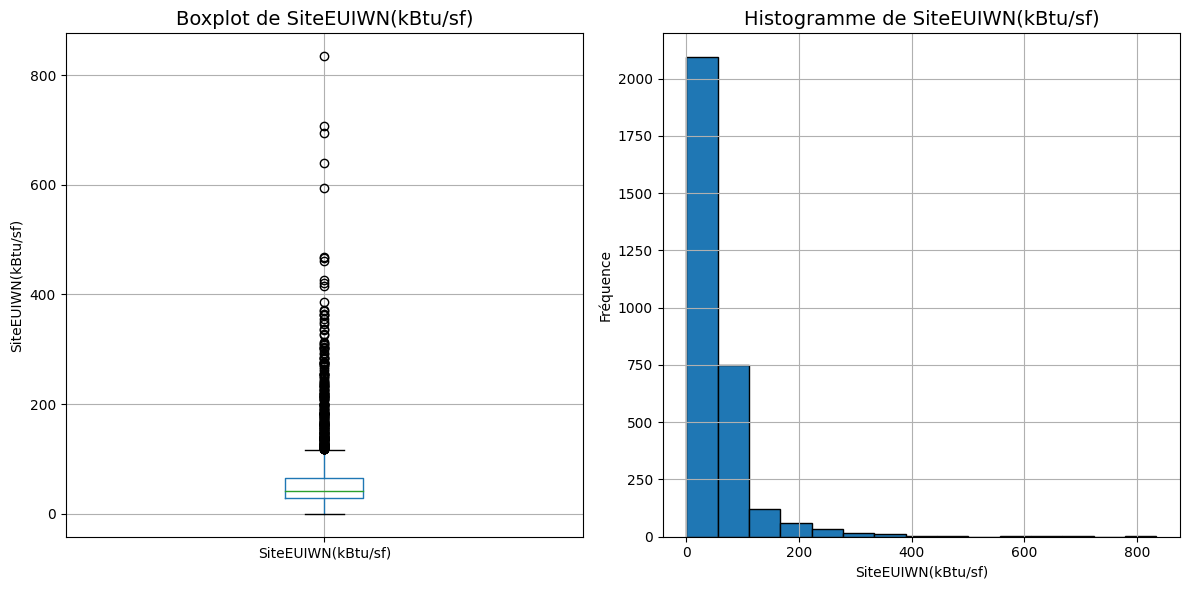

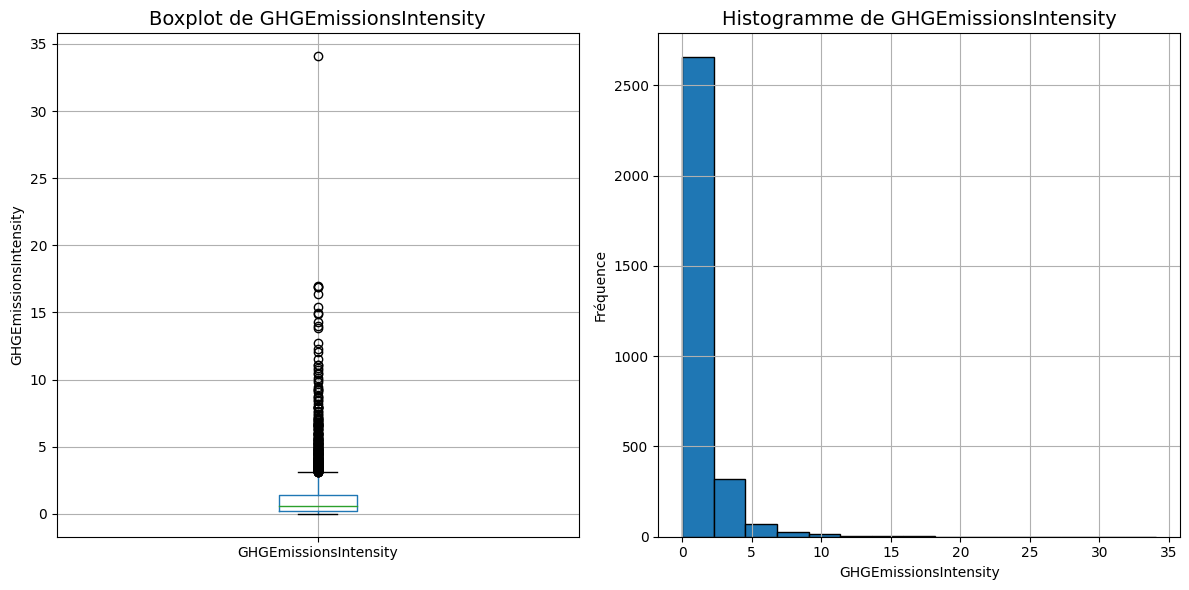

In [52]:
features = ['SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity']

# Création des visualisations
for feature in features:
    plt.figure(figsize=(12, 6))
    
    # Boxplot
    plt.subplot(1, 2, 1)
    df.boxplot(column=feature)
    plt.title(f'Boxplot de {feature}', fontsize=14)
    plt.ylabel(feature)
    
    # Histogramme
    plt.subplot(1, 2, 2)
    df[feature].hist(bins=15, edgecolor='black')
    plt.title(f'Histogramme de {feature}', fontsize=14)
    plt.xlabel(feature)
    plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()

# 1er Feature Engineering

**Filtre des bâtiments non résidentiels**

In [53]:
df = df[df['BuildingType'].str.contains('NonResidential', case=False, na=False)]

**Création d'une feature de proportion de parking**

In [54]:
df['PropertyGFAParkingPercentage'] = (df['PropertyGFAParking'] / df['PropertyGFATotal']) * 100

**Regroupement par tranche d'années de contruction**

In [55]:
bins = [0, 1950, 1970, 2000, 2025]
labels = ['Avant 1950', '1950–1970', '1970–2000', 'Apres 2000']
df['YearBuiltGroup'] = pd.cut(df['YearBuilt'], bins=bins, labels=labels)

**Taux de consommation des différentes sources d'énergie**

In [56]:
df['ElectricityProportion'] = (
    df['Electricity(kBtu)'] / df['SiteEnergyUseWN(kBtu)']
).fillna(0)
df['NaturalGasProportion'] = (
    df['NaturalGas(kBtu)'] / df['SiteEnergyUseWN(kBtu)']
).fillna(0)
df['SteamProportion'] = (
    df['SteamUse(kBtu)'] / df['SiteEnergyUseWN(kBtu)']
).fillna(0)

In [57]:
df.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'PropertyGFAParkingPercentage', 'YearBuiltGroup',
       'ElectricityProportion', 'NaturalGasProportion', 'SteamProportion'],
      dtype='object')

**Filtre des features utiles et affichage**

In [58]:
features_to_keep = [
    'BuildingType',
    'PrimaryPropertyType',
    'Neighborhood',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFAParkingPercentage',
    'YearBuiltGroup',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'LargestPropertyUseType',
    'SecondLargestPropertyUseType',
    'ThirdLargestPropertyUseType'
]
df_final = df[features_to_keep]
print("Feature engineering terminé. Aperçu des données :")
display(df_final.head())

Feature engineering terminé. Aperçu des données :


,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,YearBuiltGroup,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,NonResidential,Hotel,DOWNTOWN,1.0,12.0,88434.0,0.0,0.000000,Avant 1950,88434.0,0.0,0.0,Hotel,NaN,NaN
1,NonResidential,Hotel,DOWNTOWN,1.0,11.0,103566.0,15064.0,14.545314,1970–2000,83880.0,15064.0,4622.0,Hotel,Parking,Restaurant
2,NonResidential,Hotel,DOWNTOWN,1.0,41.0,956110.0,196718.0,20.574829,1950–1970,756493.0,0.0,0.0,Hotel,NaN,NaN
3,NonResidential,Hotel,DOWNTOWN,1.0,10.0,61320.0,0.0,0.000000,Avant 1950,61320.0,0.0,0.0,Hotel,NaN,NaN
4,NonResidential,Hotel,DOWNTOWN,1.0,18.0,175580.0,62000.0,35.311539,1970–2000,123445.0,68009.0,0.0,Hotel,Parking,Swimming Pool


In [59]:
df_final.shape

(1445, 15)

In [60]:
print(df_final['BuildingType'].value_counts())

BuildingType
NonResidential        1371
Nonresidential COS      73
Nonresidential WA        1
Name: count, dtype: int64


In [61]:
df_final.isnull().sum()

BuildingType                          0
PrimaryPropertyType                   0
Neighborhood                          0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFAParkingPercentage          0
YearBuiltGroup                        0
LargestPropertyUseTypeGFA             0
SecondLargestPropertyUseTypeGFA       0
ThirdLargestPropertyUseTypeGFA        0
LargestPropertyUseType                3
SecondLargestPropertyUseType        653
ThirdLargestPropertyUseType        1126
dtype: int64

In [62]:
categorical_features = [
    'PrimaryPropertyType',
    'Neighborhood',
    'YearBuiltGroup',
    'BuildingType', 
    'LargestPropertyUseType',
    'SecondLargestPropertyUseType',
    'ThirdLargestPropertyUseType'
]

onehot_encoder = OneHotEncoder(sparse=False, drop='first')
df_onehot = pd.DataFrame(onehot_encoder.fit_transform(df_final[categorical_features]), 
                         columns=onehot_encoder.get_feature_names_out(categorical_features),
                         index=df_final.index)

df_onehot_final = pd.concat([df_final.drop(columns=categorical_features), df_onehot], axis=1)

print("DataFrame après OneHotEncoding :")
display(df_onehot_final.head())

DataFrame après OneHotEncoding :


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,YearBuiltGroup_1970–2000,YearBuiltGroup_Apres 2000,YearBuiltGroup_Avant 1950,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,LargestPropertyUseType_Automobile Dealership,LargestPropertyUseType_Bank Branch,LargestPropertyUseType_College/University,LargestPropertyUseType_Courthouse,LargestPropertyUseType_Data Center,LargestPropertyUseType_Distribution Center,LargestPropertyUseType_Financial Office,LargestPropertyUseType_Fire Station,LargestPropertyUseType_Fitness Center/Health Club/Gym,LargestPropertyUseType_Hospital (General Medical & Surgical),LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Laboratory,LargestPropertyUseType_Library,LargestPropertyUseType_Lifestyle Center,LargestPropertyUseType_Manufacturing/Industrial Plant,LargestPropertyUseType_Medical Office,LargestPropertyUseType_Movie Theater,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Museum,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Education,LargestPropertyUseType_Other - Entertainment/Public Assembly,LargestPropertyUseType_Other - Lodging/Residential,LargestPropertyUseType_Other - Mall,LargestPropertyUseType_Other - Public Services,LargestPropertyUseType_Other - Recreation,LargestPropertyUseType_Other - Restaurant/Bar,LargestPropertyUseType_Other - Services,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Performing Arts,"LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)",LargestPropertyUseType_Police Station,LargestPropertyUseType_Pre-school/Daycare,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,"LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)",LargestPropertyUseType_Residence Hall/Dormitory,LargestPropertyUseType_Residential Care Facility,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Worship Facility,LargestPropertyUseType_nan,SecondLargestPropertyUseType_Automobile Dealership,SecondLargestPropertyUseType_Bank Branch,SecondLargestPropertyUseType_Bar/Nightclub,SecondLargestPropertyUseType_College/University,SecondLargestPropertyUseType_Convenience Store without Gas Station,SecondLargestPropertyUseType_

In [63]:
df_onehot_final.shape

(1445, 187)

# Développement du premier modèle

**Préparation des datasets train et test (target = SiteEUIWN)**

In [64]:
df_onehot_final['SiteEUIWN(kBtu/sf)'] = df['SiteEUIWN(kBtu/sf)']

X = df_onehot_final.drop(columns=['SiteEUIWN(kBtu/sf)'])
y = df_onehot_final['SiteEUIWN(kBtu/sf)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Taille du jeu d'entraînement :", X_train.shape)
print("Taille du jeu de test :", X_test.shape)

Taille du jeu d'entraînement : (1156, 187)
Taille du jeu de test : (289, 187)


In [65]:
df_onehot_final.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,YearBuiltGroup_1970–2000,YearBuiltGroup_Apres 2000,YearBuiltGroup_Avant 1950,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,LargestPropertyUseType_Automobile Dealership,LargestPropertyUseType_Bank Branch,LargestPropertyUseType_College/University,LargestPropertyUseType_Courthouse,LargestPropertyUseType_Data Center,LargestPropertyUseType_Distribution Center,LargestPropertyUseType_Financial Office,LargestPropertyUseType_Fire Station,LargestPropertyUseType_Fitness Center/Health Club/Gym,LargestPropertyUseType_Hospital (General Medical & Surgical),LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Laboratory,LargestPropertyUseType_Library,LargestPropertyUseType_Lifestyle Center,LargestPropertyUseType_Manufacturing/Industrial Plant,LargestPropertyUseType_Medical Office,LargestPropertyUseType_Movie Theater,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Museum,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Education,LargestPropertyUseType_Other - Entertainment/Public Assembly,LargestPropertyUseType_Other - Lodging/Residential,LargestPropertyUseType_Other - Mall,LargestPropertyUseType_Other - Public Services,LargestPropertyUseType_Other - Recreation,LargestPropertyUseType_Other - Restaurant/Bar,LargestPropertyUseType_Other - Services,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Performing Arts,"LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)",LargestPropertyUseType_Police Station,LargestPropertyUseType_Pre-school/Daycare,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,"LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)",LargestPropertyUseType_Residence Hall/Dormitory,LargestPropertyUseType_Residential Care Facility,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Worship Facility,LargestPropertyUseType_nan,SecondLargestPropertyUseType_Automobile Dealership,SecondLargestPropertyUseType_Bank Branch,SecondLargestPropertyUseType_Bar/Nightclub,SecondLargestPropertyUseType_College/University,SecondLargestPropertyUseType_Convenience Store without Gas Station,SecondLargestPropertyUseType_

**DummyRegressor**

In [66]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)

dummy_r2 = r2_score(y_test, y_dummy_pred)
dummy_rmse = np.sqrt(mean_squared_error(y_test, y_dummy_pred))
dummy_mae = mean_absolute_error(y_test, y_dummy_pred)

print(f"R² : {dummy_r2:.3f}")
print(f"RMSE : {dummy_rmse:.3f}")
print(f"MAE : {dummy_mae:.3f}")

R² : -0.011
RMSE : 63.799
MAE : 42.886


##### **Ridge Regression**

In [67]:
ridge = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge_grid = GridSearchCV(ridge, param_grid, scoring='r2', cv=5, return_train_score=True)
start_time = time.time()
ridge_grid.fit(X_train, y_train)
train_time = time.time() - start_time

ridge_best = ridge_grid.best_estimator_
start_time = time.time()
ridge_y_pred = ridge_best.predict(X_test)
predict_time = time.time() - start_time

ridge_r2 = r2_score(y_test, ridge_y_pred)
ridge_rmse = mean_squared_error(y_test, ridge_y_pred, squared=False)
ridge_mae = mean_absolute_error(y_test, ridge_y_pred)

print(f"Ridge Regression - Meilleur alpha: {ridge_grid.best_params_['alpha']}")
print(f"Temps d'entraînement: {train_time:.2f} secondes")
print(f"Temps de prédiction: {predict_time:.2f} secondes")
print(f"R² (test): {ridge_r2:.3f}")
print(f"RMSE (test): {ridge_rmse:.3f}")
print(f"MAE (test): {ridge_mae:.3f}")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.22624e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.05077e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression - Meilleur alpha: 10
Temps d'entraînement: 0.91 secondes
Temps de prédiction: 0.01 secondes
R² (test): 0.319
RMSE (test): 52.385
MAE (test): 34.764


**Lasso Regression**

In [68]:
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

lasso = Lasso(max_iter=10000)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2', return_train_score=True)
start_time = time.time()
lasso_grid.fit(X_train, y_train)
train_time = time.time() - start_time

lasso_best = lasso_grid.best_estimator_
start_time = time.time()
y_pred_lasso = lasso_best.predict(X_test)
predict_time = time.time() - start_time

lasso_test_r2 = r2_score(y_test, y_pred_lasso)
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_test_mae = mean_absolute_error(y_test, y_pred_lasso)

print(f"Lasso Regression - Meilleur alpha : {lasso_grid.best_params_['alpha']}")
print(f"Temps d'entraînement: {train_time:.2f} secondes")
print(f"Temps de prédiction: {predict_time:.2f} secondes")
print(f"Train R² (CV) : {lasso_grid.best_score_:.3f}")
print(f"Test R² : {lasso_test_r2:.3f}, RMSE : {lasso_test_rmse:.3f}, MAE : {lasso_test_mae:.3f}")

Lasso Regression - Meilleur alpha : 0.1
Temps d'entraînement: 3.14 secondes
Temps de prédiction: 0.00 secondes
Train R² (CV) : 0.311
Test R² : 0.400, RMSE : 49.179, MAE : 32.925


**ElasticNet Regression**

In [69]:
elasticnet_params = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.2, 0.5, 0.8]
}

elasticnet = ElasticNet(max_iter=10000)
elasticnet_grid = GridSearchCV(elasticnet, elasticnet_params, cv=5, scoring='r2', return_train_score=True)
start_time = time.time()
elasticnet_grid.fit(X_train, y_train)
train_time = time.time() - start_time

elasticnet_best = elasticnet_grid.best_estimator_
start_time = time.time()
y_pred_elasticnet = elasticnet_best.predict(X_test)
predict_time = time.time() - start_time

elasticnet_test_r2 = r2_score(y_test, y_pred_elasticnet)
elasticnet_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_elasticnet))
elasticnet_test_mae = mean_absolute_error(y_test, y_pred_elasticnet)

print(f"ElasticNet - Meilleur alpha : {elasticnet_grid.best_params_['alpha']}")
print(f"Meilleur l1_ratio : {elasticnet_grid.best_params_['l1_ratio']}")
print(f"Temps d'entraînement: {train_time:.2f} secondes")
print(f"Temps de prédiction: {predict_time:.2f} secondes")
print(f"Train R² (CV) : {elasticnet_grid.best_score_:.3f}")
print(f"Test R² : {elasticnet_test_r2:.3f}, RMSE : {elasticnet_test_rmse:.3f}, MAE : {elasticnet_test_mae:.3f}")

ElasticNet - Meilleur alpha : 0.01
Meilleur l1_ratio : 0.5
Temps d'entraînement: 7.18 secondes
Temps de prédiction: 0.00 secondes
Train R² (CV) : 0.329
Test R² : 0.342, RMSE : 51.464, MAE : 34.622


**Préparation des datasets train et test (target = GHGEmissionsIntensity)**

In [70]:
df_onehot_final['GHGEmissionsIntensity'] = df['GHGEmissionsIntensity']

X = df_onehot_final.drop(columns=['GHGEmissionsIntensity'])
y = df_onehot_final['GHGEmissionsIntensity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Taille du jeu d'entraînement :", X_train.shape)
print("Taille du jeu de test :", X_test.shape)

Taille du jeu d'entraînement : (1156, 188)
Taille du jeu de test : (289, 188)


In [71]:
df_onehot_final.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,YearBuiltGroup_1970–2000,YearBuiltGroup_Apres 2000,YearBuiltGroup_Avant 1950,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,LargestPropertyUseType_Automobile Dealership,LargestPropertyUseType_Bank Branch,LargestPropertyUseType_College/University,LargestPropertyUseType_Courthouse,LargestPropertyUseType_Data Center,LargestPropertyUseType_Distribution Center,LargestPropertyUseType_Financial Office,LargestPropertyUseType_Fire Station,LargestPropertyUseType_Fitness Center/Health Club/Gym,LargestPropertyUseType_Hospital (General Medical & Surgical),LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Laboratory,LargestPropertyUseType_Library,LargestPropertyUseType_Lifestyle Center,LargestPropertyUseType_Manufacturing/Industrial Plant,LargestPropertyUseType_Medical Office,LargestPropertyUseType_Movie Theater,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Museum,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Education,LargestPropertyUseType_Other - Entertainment/Public Assembly,LargestPropertyUseType_Other - Lodging/Residential,LargestPropertyUseType_Other - Mall,LargestPropertyUseType_Other - Public Services,LargestPropertyUseType_Other - Recreation,LargestPropertyUseType_Other - Restaurant/Bar,LargestPropertyUseType_Other - Services,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Performing Arts,"LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)",LargestPropertyUseType_Police Station,LargestPropertyUseType_Pre-school/Daycare,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,"LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)",LargestPropertyUseType_Residence Hall/Dormitory,LargestPropertyUseType_Residential Care Facility,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Worship Facility,LargestPropertyUseType_nan,SecondLargestPropertyUseType_Automobile Dealership,SecondLargestPropertyUseType_Bank Branch,SecondLargestPropertyUseType_Bar/Nightclub,SecondLargestPropertyUseType_College/University,SecondLargestPropertyUseType_Convenience Store without Gas Station,SecondLargestPropertyUseType_

**DummyRegressor**

In [72]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)

dummy_r2 = r2_score(y_test, y_dummy_pred)
dummy_rmse = np.sqrt(mean_squared_error(y_test, y_dummy_pred))
dummy_mae = mean_absolute_error(y_test, y_dummy_pred)

print(f"R² : {dummy_r2:.3f}")
print(f"RMSE : {dummy_rmse:.3f}")
print(f"MAE : {dummy_mae:.3f}")

R² : -0.022
RMSE : 1.540
MAE : 1.217


##### **Ridge Regression**

In [73]:
ridge = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge_grid = GridSearchCV(ridge, param_grid, scoring='r2', cv=5, return_train_score=True)
start_time = time.time()
ridge_grid.fit(X_train, y_train)
train_time = time.time() - start_time

ridge_best = ridge_grid.best_estimator_
start_time = time.time()
ridge_y_pred = ridge_best.predict(X_test)
predict_time = time.time() - start_time

ridge_r2 = r2_score(y_test, ridge_y_pred)
ridge_rmse = mean_squared_error(y_test, ridge_y_pred, squared=False)
ridge_mae = mean_absolute_error(y_test, ridge_y_pred)

print(f"Ridge Regression - Meilleur alpha: {ridge_grid.best_params_['alpha']}")
print(f"Temps d'entraînement: {train_time:.2f} secondes")
print(f"Temps de prédiction: {predict_time:.2f} secondes")
print(f"R² (test): {ridge_r2:.3f}")
print(f"RMSE (test): {ridge_rmse:.3f}")
print(f"MAE (test): {ridge_mae:.3f}")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.22394e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.05041e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression - Meilleur alpha: 10
Temps d'entraînement: 0.86 secondes
Temps de prédiction: 0.01 secondes
R² (test): 0.631
RMSE (test): 0.925
MAE (test): 0.646


**Lasso Regression**

In [74]:
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

lasso = Lasso(max_iter=10000)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2', return_train_score=True)
start_time = time.time()
lasso_grid.fit(X_train, y_train)
train_time = time.time() - start_time

lasso_best = lasso_grid.best_estimator_
start_time = time.time()
y_pred_lasso = lasso_best.predict(X_test)
predict_time = time.time() - start_time

lasso_test_r2 = r2_score(y_test, y_pred_lasso)
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_test_mae = mean_absolute_error(y_test, y_pred_lasso)

print(f"Lasso Regression - Meilleur alpha : {lasso_grid.best_params_['alpha']}")
print(f"Temps d'entraînement: {train_time:.2f} secondes")
print(f"Temps de prédiction: {predict_time:.2f} secondes")
print(f"Train R² (CV) : {lasso_grid.best_score_:.3f}")
print(f"Test R² : {lasso_test_r2:.3f}, RMSE : {lasso_test_rmse:.3f}, MAE : {lasso_test_mae:.3f}")

Lasso Regression - Meilleur alpha : 0.01
Temps d'entraînement: 1.91 secondes
Temps de prédiction: 0.01 secondes
Train R² (CV) : 0.616
Test R² : 0.679, RMSE : 0.862, MAE : 0.621


**ElasticNet Regression**

In [75]:
elasticnet_params = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.2, 0.5, 0.8]
}

elasticnet = ElasticNet(max_iter=10000)
elasticnet_grid = GridSearchCV(elasticnet, elasticnet_params, cv=5, scoring='r2', return_train_score=True)
start_time = time.time()
elasticnet_grid.fit(X_train, y_train)
train_time = time.time() - start_time

elasticnet_best = elasticnet_grid.best_estimator_
start_time = time.time()
y_pred_elasticnet = elasticnet_best.predict(X_test)
predict_time = time.time() - start_time

elasticnet_test_r2 = r2_score(y_test, y_pred_elasticnet)
elasticnet_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_elasticnet))
elasticnet_test_mae = mean_absolute_error(y_test, y_pred_elasticnet)

print(f"ElasticNet - Meilleur alpha : {elasticnet_grid.best_params_['alpha']}")
print(f"Meilleur l1_ratio : {elasticnet_grid.best_params_['l1_ratio']}")
print(f"Temps d'entraînement: {train_time:.2f} secondes")
print(f"Temps de prédiction: {predict_time:.2f} secondes")
print(f"Train R² (CV) : {elasticnet_grid.best_score_:.3f}")
print(f"Test R² : {elasticnet_test_r2:.3f}, RMSE : {elasticnet_test_rmse:.3f}, MAE : {elasticnet_test_mae:.3f}")

ElasticNet - Meilleur alpha : 0.01
Meilleur l1_ratio : 0.2
Temps d'entraînement: 5.88 secondes
Temps de prédiction: 0.00 secondes
Train R² (CV) : 0.623
Test R² : 0.628, RMSE : 0.929, MAE : 0.645


# Amélioration du feature engineering

**Regroupement de valeurs pour les types de propriétés**

In [76]:
property_use_mapping = {
    # Hébergement
    'Hotel': 'Hospitality',
    'Residence Hall/Dormitory': 'Hospitality',
    'Residential Care Facility': 'Hospitality',
    'Other - Lodging/Residential': 'Hospitality',

    # Commerce
    'Retail Store': 'Commercial',
    'Supermarket/Grocery Store': 'Commercial',
    'Strip Mall': 'Commercial',
    'Automobile Dealership': 'Commercial',
    'Convenience Store without Gas Station': 'Commercial',
    'Bank Branch': 'Commercial',
    'Financial Office': 'Commercial',

    # Éducation
    'K-12 School': 'Educational',
    'College/University': 'Educational',
    'Adult Education': 'Educational',
    'Other - Education': 'Educational',
    'Vocational School': 'Educational',
    'Pre-school/Daycare': 'Educational',

    # Santé
    'Hospital (General Medical & Surgical)': 'Healthcare',
    'Medical Office': 'Healthcare',
    'Urgent Care/Clinic/Other Outpatient': 'Healthcare',
    'Other/Specialty Hospital': 'Healthcare',
    'Laboratory': 'Healthcare',

    # Infrastructure
    'Parking': 'Infrastructure',
    'Self-Storage Facility': 'Infrastructure',
    'Non-Refrigerated Warehouse': 'Infrastructure',
    'Refrigerated Warehouse': 'Infrastructure',
    'Distribution Center': 'Infrastructure',
    'Fire Station': 'Infrastructure',
    'Police Station': 'Infrastructure',
    'Prison/Incarceration': 'Infrastructure',

    # Loisirs
    'Fitness Center/Health Club/Gym': 'Recreation',
    'Swimming Pool': 'Recreation',
    'Social/Meeting Hall': 'Recreation',
    'Performing Arts': 'Recreation',
    'Museum': 'Recreation',
    'Movie Theater': 'Recreation',
    'Lifestyle Center': 'Recreation',
    'Other - Entertainment/Public Assembly': 'Recreation',
    'Other - Recreation': 'Recreation',
    'Bar/Nightclub': 'Recreation',

    # Alimentation
    'Restaurant': 'FoodService',
    'Other - Restaurant/Bar': 'FoodService',
    'Fast Food Restaurant': 'FoodService',
    'Food Service': 'FoodService',
    'Food Sales': 'FoodService',

    # Secteur industriel
    'Manufacturing/Industrial Plant': 'Industrial',

    # Secteur technologique
    'Data Center': 'Technology',
    'Other - Technology/Science': 'Technology',

    # Usage mixte
    'Mixed Use Property': 'MixedUse',

    # Services religieux
    'Worship Facility': 'Religious',

    # Administration
    'Office': 'Office',
    'Large Office': 'Office',
    'Small- and Mid-Sized Office': 'Office',
    'Courthouse': 'Office',

    # Autres
    'Other': 'Other',
    'Other - Public Services': 'Other',
    'Other - Lodging/Residential': 'Other',
    'Other - Services': 'Other',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)': 'Other',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Other',
    'Other - Utility': 'Other',
    'Other/Specialty Hospital': 'Other',
    'Other - Mall': 'Other',
    'Other - Entertainment/Public Assembly': 'Other'
}

for col in ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:
    df_final[col] = df_final[col].map(property_use_mapping).fillna('Other')

/tmp/ipykernel_24/969900939.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[col] = df_final[col].map(property_use_mapping).fillna('Other')
/tmp/ipykernel_24/969900939.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[col] = df_final[col].map(property_use_mapping).fillna('Other')
/tmp/ipykernel_24/969900939.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

**Encodage des proportions par type d'utilisation**

In [77]:
all_property_types = pd.unique(
    df_final[['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']].values.ravel()
)

for prop_type in all_property_types:
    df_final[f'Proportion_{prop_type}'] = (
        (df_final['LargestPropertyUseType'] == prop_type) * df_final['LargestPropertyUseTypeGFA'] / df_final['PropertyGFATotal'] +
        (df_final['SecondLargestPropertyUseType'] == prop_type) * df_final['SecondLargestPropertyUseTypeGFA'] / df_final['PropertyGFATotal'] +
        (df_final['ThirdLargestPropertyUseType'] == prop_type) * df_final['ThirdLargestPropertyUseTypeGFA'] / df_final['PropertyGFATotal']
    )

df_final = df_final.drop(columns=[
    'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
    'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'
])

/tmp/ipykernel_24/2115948109.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[f'Proportion_{prop_type}'] = (
/tmp/ipykernel_24/2115948109.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[f'Proportion_{prop_type}'] = (
/tmp/ipykernel_24/2115948109.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [78]:
df_final.head()

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,YearBuiltGroup,Proportion_Hospitality,Proportion_Other,Proportion_Infrastructure,Proportion_FoodService,Proportion_Recreation,Proportion_Technology,Proportion_Office,Proportion_Educational,Proportion_Commercial,Proportion_Healthcare,Proportion_Religious,Proportion_Industrial
0,NonResidential,Hotel,DOWNTOWN,1.0,12.0,88434.0,0.0,0.000000,Avant 1950,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NonResidential,Hotel,DOWNTOWN,1.0,11.0,103566.0,15064.0,14.545314,1970–2000,0.809918,0.0,0.145453,0.044629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NonResidential,Hotel,DOWNTOWN,1.0,41.0,956110.0,196718.0,20.574829,1950–1970,0.791220,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NonResidential,Hotel,DOWNTOWN,1.0,10.0,61320.0,0.0,0.000000,Avant 1950,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NonResidential,Hotel,DOWNTOWN,1.0,18.0,175580.0,62000.0,35.311539,1970–2000,0.703070,0.0,0.387339,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
df_final.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,Proportion_Hospitality,Proportion_Other,Proportion_Infrastructure,Proportion_FoodService,Proportion_Recreation,Proportion_Technology,Proportion_Office,Proportion_Educational,Proportion_Commercial,Proportion_Healthcare,Proportion_Religious,Proportion_Industrial
count,1445.000000,1445.000000,1.445000e+03,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000
mean,1.066436,4.310035,1.103754e+05,14288.159170,6.749118,0.056485,0.119036,0.258849,0.011485,0.033745,0.002569,0.285400,0.043732,0.108515,0.038174,0.046535,0.005028
std,0.511382,6.480159,1.878614e+05,44645.729669,14.568383,0.221927,0.306427,0.419229,0.078809,0.171963,0.037013,0.375567,0.203666,0.281542,0.187370,0.211407,0.067587
min,1.000000,1.000000,1.128500e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,2.876000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,4.695800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,1.025000e+05,0.000000,0.000000,0.000000,0.000000,0.390818,0.000000,0.000000,0.000000,0.614002,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,76.000000,1.952220e+06,512608.000000,89.502252,1.513747,3.437652,6.426849,1.000000,1.499970,1.000000,1.268406,1.730201,1.500000,2.697535,1.607691,1.138481


**TargetEncoding avec target = SiteEUIWN(kBtu/sf)**

In [80]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1445 entries, 0 to 3375
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   BuildingType                  1445 non-null   object  
 1   PrimaryPropertyType           1445 non-null   object  
 2   Neighborhood                  1445 non-null   object  
 3   NumberofBuildings             1445 non-null   float64 
 4   NumberofFloors                1445 non-null   float64 
 5   PropertyGFATotal              1445 non-null   float64 
 6   PropertyGFAParking            1445 non-null   float64 
 7   PropertyGFAParkingPercentage  1445 non-null   float64 
 8   YearBuiltGroup                1445 non-null   category
 9   Proportion_Hospitality        1445 non-null   float64 
 10  Proportion_Other              1445 non-null   float64 
 11  Proportion_Infrastructure     1445 non-null   float64 
 12  Proportion_FoodService        1445 non-null   float64

In [81]:
target_column = 'SiteEUIWN(kBtu/sf)'
categorical_columns = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuiltGroup']

df_final[target_column] = df[target_column]

X = df_final.drop(columns=[target_column])
y = df_final[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

target_encoder = TargetEncoder(cols=categorical_columns)

X_train_encoded = target_encoder.fit_transform(X_train, y_train)

X_test_encoded = target_encoder.transform(X_test)

print("Aperçu des données d'entraînement après Target Encoding :")
display(X_train_encoded.head())

print("\nAperçu des données de test après Target Encoding :")
display(X_test_encoded.head())

Aperçu des données d'entraînement après Target Encoding :


,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,YearBuiltGroup,Proportion_Hospitality,Proportion_Other,Proportion_Infrastructure,Proportion_FoodService,Proportion_Recreation,Proportion_Technology,Proportion_Office,Proportion_Educational,Proportion_Commercial,Proportion_Healthcare,Proportion_Religious,Proportion_Industrial
3356,76.283607,100.262101,87.789681,1.0,6.0,345290.0,85028.0,24.625098,91.965589,0.0,0.000000,0.243280,0.0,0.0,0.000000,0.308431,0.0,0.0,0.438828,0.0,0.0
434,76.283607,62.740724,55.609465,1.0,1.0,53620.0,0.0,0.000000,66.229521,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
2143,76.283607,37.030784,55.609465,1.0,2.0,20400.0,0.0,0.000000,66.229521,0.0,0.000000,0.735294,0.0,0.0,0.000000,0.264706,0.0,0.0,0.000000,0.0,0.0
1668,76.283607,62.740724,70.494976,1.0,2.0,30659.0,0.0,0.000000,84.936499,0.0,0.000000,0.282234,0.0,0.0,0.009296,0.889201,0.0,0.0,0.000000,0.0,0.0
1105,76.283607,65.100982,87.789681,1.0,5.0,206126.0,79284.0,38.463852,91.965589,0.0,0.040383,0.355011,0.0,0.0,0.000000,0.494557,0.0,0.0,0.000000,0.0,0.0



Aperçu des données de test après Target Encoding :


,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,YearBuiltGroup,Proportion_Hospitality,Proportion_Other,Proportion_Infrastructure,Proportion_FoodService,Proportion_Recreation,Proportion_Technology,Proportion_Office,Proportion_Educational,Proportion_Commercial,Proportion_Healthcare,Proportion_Religious,Proportion_Industrial
502,76.283607,111.943994,81.383335,3.0,1.0,102133.0,0.0,0.0,84.936499,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.051834,0.0,0.0,0.0
394,76.283607,37.030784,84.747260,1.0,3.0,64660.0,0.0,0.0,84.936499,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2035,76.283607,111.943994,55.609465,1.0,1.0,27933.0,0.0,0.0,77.067832,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
75,108.031248,111.943994,79.971215,1.0,2.0,262048.0,0.0,0.0,66.229521,0.0,1.129564,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2005,76.283607,111.943994,55.609465,1.0,1.0,20819.0,0.0,0.0,84.936499,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0


In [82]:
numerical_features = df_final.select_dtypes(include=[np.number]).columns

skewness = df_final[numerical_features].skew()

high_skew_features = skewness[abs(skewness) > 5].index
moderate_skew_features = skewness[(abs(skewness) > 0.75) & (abs(skewness) <= 5)].index  # Skewness modérée

print("\nFeatures avec skewness très élevée (> 5) :")
print(high_skew_features)

print("\nFeatures avec skewness modérée (0.75 < skewness <= 5) :")
print(moderate_skew_features)

qt = QuantileTransformer(output_distribution='normal', random_state=42)
for feature in high_skew_features:
    df_final[feature] = qt.fit_transform(df_final[[feature]])
    print(f"Transformation QuantileTransformer appliquée à {feature}")

for feature in moderate_skew_features:
    if (df_final[feature] >= 0).all():
        df_final[feature] = np.log1p(df_final[feature])
        print(f"Transformation log(1+x) appliquée à {feature}")
    else:
        print(f"Log(1+x) ignoré pour {feature} car des valeurs négatives existent.")

new_skewness = df_final[numerical_features].skew()
print("\nSkewness des features numériques après transformation :")
print(new_skewness)


Features avec skewness très élevée (> 5) :
Index(['NumberofBuildings', 'Proportion_FoodService', 'Proportion_Recreation',
       'Proportion_Technology', 'Proportion_Healthcare',
       'Proportion_Industrial'],
      dtype='object')

Features avec skewness modérée (0.75 < skewness <= 5) :
Index(['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFAParkingPercentage', 'Proportion_Hospitality',
       'Proportion_Other', 'Proportion_Infrastructure', 'Proportion_Office',
       'Proportion_Educational', 'Proportion_Commercial',
       'Proportion_Religious', 'SiteEUIWN(kBtu/sf)'],
      dtype='object')
Transformation QuantileTransformer appliquée à NumberofBuildings
Transformation QuantileTransformer appliquée à Proportion_FoodService
Transformation QuantileTransformer appliquée à Proportion_Recreation
Transformation QuantileTransformer appliquée à Proportion_Technology
Transformation QuantileTransformer appliquée à Proportion_Healthcare
Transformation Quantile